# Machine Learning and Prediction of Disposal Outlet by Waste Description

This test case uses data relating to hazardous chemical waste and attempts to determine the fate, or disposal outlet / waste company that can move the waste towards it's final end point. The problem is that of choosing which of many disposal outlets would be most suitable, i.e. it is a multiclassification exercise. The data is sourced from records of succesfull waste transactions and includes a general description, chemical components, various hazardous classification descriptors and a disposal outlet. 

Having some considerable experience with the data set beforehand there are a few points to raise before we go exploring. The data source is from an very old database (c.1985) and data input has largely been via free text entry fields, made by a many different users over a period of about 15 years. The quality and consistency of the result is extremely poor. 

There are many opportunities for standardised terms but with no drop down menu options and no input validation we find that various phrases have been used for the same thing. The few standardised terms take the form of code numbers, i.e. they are a string of number characters but represent categorical rather than scalar values. Also because of their origin in Excel these numbers are sometimes preceded with an apostophe, used to force Excel to treat number characters as text. All descriptors can be divided even further when we add the many more variations created by typos and spelling mistakes. 

As a human consumer the descriptors provided form a common meaning which when interogated on a one by one basis provide a useful data record, however when considering more than one record using an automated approach the similarity of meaning or semantics is considerably more difficult. To this end some inspiration has come from studies involving the multiclassification of semantics, in the form of food and wine reviews. [1]

The approach in this reference relates to the similarity of meaning in a variety of diverse terms, i.e. natural language, a word processor Word2Vec is trained on a very large corpus of natural language terms. In our case the vocabulary is very limited, there are many acronyms, the language is rich in chemical names and specialised technical terms. Word embedding, vectorisation can be achieved using a far reduced corpus [2].

After first of all, exploring the data, cleansing, and preprosessing a comparison is made between RandomForrestClassifier and XGBoost, both popular approaches to classification problems.

Inspriation for this approach came from: 
1. https://github.com/JungeAlexander/kaggle-amazon-fine-food-reviews
2. https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/



# Data Exploration

We will be providing a pipeline for future data processing, as we explore each section we will do some rudimentary analysis, build and test a segment of the pipe and visualise the result. Finally we will then put all of the pieces together and produce a clean set of data for use in our multiclassification process.

Import a few libraries

In [1]:
import pandas as pd                                        # Used for importing data and transformations
import numpy as np                                         # Provides mathmatical functions and randomisers
import copy                                                # Used to copy objects
import matplotlib.pyplot as plt                            # Plot charts
import seaborn as sn                                       # Visualisation tools
import warnings                                            # Manage python system warnings
warnings.simplefilter('ignore')
sn.color_palette("flare", as_cmap=True)
from random import shuffle                                 # Dataset randomiser
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk as nltk
import string

from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier  
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure

Import the data and preliminay look at the shape and data types.

In [2]:
df = pd.read_csv("data/raw3.csv")
print(f'The primary data set has {len(df.columns)} columns and {len(df)} rows.')
print('Data types:')
print(df.dtypes.value_counts())
df.head(2)

The primary data set has 42 columns and 21045 rows.
Data types:
object     40
float64     2
dtype: int64


,DRUM ID,QTY,Cont. Size,Quantity (Kg),Description,Components and Concentrations,Hazard Codes,UN Number,Proper Shipping Name,Class,...,24-26 Weeks,>6 Months,Origin District,Destination District,Date Out,DR Code,Tonnage,Municipal Source,Column1,EWC2
0,NaN,80,60,1.5,EMPTY PLASTIC DRUMS (60L),NIL HAZARDOUS COMPONENTS,N/C,NCAD,NOT CLASSIFIED AS DANGEROUS FOR TRANSPORT,N/C,...,0,0,SHEFFIELD,LEEDS,11/01/2023,R03 - RECYCLING OF ORGANIC SUBSTANCES,0.0015,No,R03 - Recycling of organic substances,150110
1,NaN,4,30,2.0,EMPTY PLASTIC DRUMS (30L),Nil hazardous components,N/C,NCAD,NOT CLASSIFIED AS DANGEROUS FOR TRANSPORT,N/C,...,0,0,SHEFFIELD,LEEDS,11/01/2023,R03 - RECYCLING OF ORGANIC SUBSTANCES,0.002,No,R03 - Recycling of organic substances,150110


In [3]:
# A helper function for visualisation
def create_histogram_from_column(dataframe, column_name, width, height):
    plt.figure(figsize=(width, height))
    dataframe[column_name].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

The classifier that we are trying to predict is the disposal outlet.

The usage distribution of each of the 47 outlets:
WASTECARE NORMANTON         2669
RED INDUSTRIES              1942
FCC BBM                     1857
CLEAN PAK                   1710
ROBERT HOPKINS              1657
MALARY                      1439
MYTUM MALTINGS               958
VEOLIA NORWOOD               864
MULBERRY                     694
VEOLIA ELLESMERE PORT        657
SWARF                        654
BURSCOUGH                    491
CASTLE                       460
WEDNESBURY                   448
LOUGHBOROUGH                 424
AVANTI                       404
ERP                          374
TRADEBE FAWLEY               358
OIL RECOVERIES               351
PACKCARE                     311
ECO BAT                      290
SLICKER                      235
MULBERRY KNOWSLEY            231
FCC ECCLESFIELD              222
FCC KNOSTROP                 176
ATTLEBOROUGH                 164
ESYNERGY                     155
FUTURE                       108
MYTUM SHERBURN            

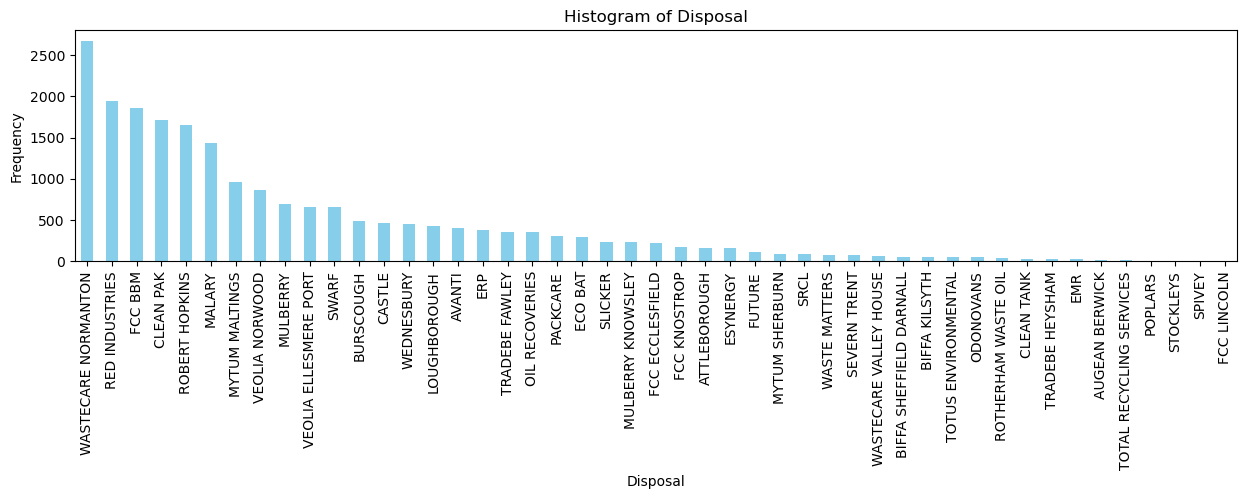

In [4]:
# Find the unique values for Disposal and arrange alphabetically
outlets = pd.DataFrame({'Disposal': df['Disposal'].unique()})
outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

print(f'The usage distribution of each of the {len(outlets)} outlets:')

# Remove any rows with empty disposal columns
df.dropna(subset=['Disposal'], inplace=True)

# Count occurrences of each label
label_counts = df['Disposal'].value_counts()
print(label_counts)

# Add a visualisation
create_histogram_from_column(df, 'Disposal', 15, 3)

Disposal outlets that only appear a few (less than 5) times in our dataset don't offer sufficient information for training purposes, similarly there are quite a few columns that we could also remomve. RowTrimmer and ColumnTrimmer are two classes that extend the BaseEstimator class and can be inserted into a pipeline for trimming purposes.

## Row Trimmer

In [5]:
# Create a Row Trimmer by extending the BaseEstimator class
class RowTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, min_count=5):
        self.min_count = min_count

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        before_trim_size = len(X)

        # Drop rows with nothing in the Disposal Column
        X.dropna(subset=['Disposal'], inplace=True)
        label_counts = X['Disposal'].value_counts()
        
        # Find the indices of labels that appear less than min_count times.
        unique_labels = label_counts[label_counts < self.min_count].index

        # Using the index value, filter out rows where the label appears only once.
        X = X[~X['Disposal'].isin(unique_labels)]

        # Reset row indexing
        X = X.reset_index(drop=True)
        after_trim_size = len(X)

        # After trimming rows that we don't want, reset outlets.
        outlets = pd.DataFrame({'Disposal': df['Disposal'].unique()})
        outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

        print(f'RowTrimmer: Out of {len(label_counts)} outlets, {len(unique_labels)} appear less than { self.min_count} times. {before_trim_size - after_trim_size} rows have been trimmed.')
        print(f'RowTrimmer: {X.shape}')
        return X

In [6]:
# Test RowTrimmer
from sklearn.pipeline import Pipeline
rt_params = {
    'rt__min_count': 5
}

# Create a pipeline to build a model
rt_pipe = Pipeline([
    ('rt', RowTrimmer())
])

rt_pipe.set_params(**rt_params)

# Example usage of the pipeline
rt_trim = rt_pipe.fit_transform(df)

RowTrimmer: Out of 47 outlets, 2 appear less than 5 times. 3 rows have been trimmed.
RowTrimmer: (21042, 42)


Having trimmed away a few unhelpful rows, we can now consider columns. Of the 42 or so columns, there are only a few that can be used as descriptors and a second data file labels.xlsx, is provided that lists all columns and indicates which ones are useful.

After a bit of tidying up in the In/Out column, i.e filling in any missing values or not either IN or OUT. We can trim off any excess columns that arn't of any interest and produce a lighter weight data set.

## Column Trimmer

In [7]:
# Define a custom transformer to clean column names
class CleanColumnNamesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.columns = X.columns.str.strip() #.str.replace(' ', '_')
        return X

In [8]:
# Define the ColumnTrimmer class
class ColumnTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, filename=''):
        self.filename = filename

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Load the excel file
        lb = pd.read_excel(self.filename, header=0)
        lb.head(2)

        # Fill in any missing values in the In/Out column.
        lb.fillna("OUT", inplace=True)

        # Replace any values that are not either IN or OUT.
        temp = [value if value in ["IN", "OUT"] else "OUT" for value in lb['In/Out'].values] 
        lb['In/Out'] = temp

        # Filter the labels for those where In/Out == IN
        features = lb[lb['In/Out']=='IN'].astype('str')
        self.columns_to_keep = [col.strip() for col in features['Column'].values]
        #self.columns_to_keep = [col.strip().replace(' ', '_') for col in features['Column'].values]

        # Select only specified columns
        if self.columns_to_keep is not None and any(self.columns_to_keep):
            transformed_df = X[self.columns_to_keep]  
        else:
            transformed_df = X
        
        print(f'ColumnTrimmer: After trimming {len(transformed_df.columns)} columns remain.')
        print(f'ColumnTrimmer: {transformed_df.shape}')
        return transformed_df

In [9]:
# Redefine params
ct_params = {
    'ct__filename': 'data/labels.xlsx'
}

# Create a pipeline to build a model
ct_pipe = Pipeline([
    ('cc', CleanColumnNamesTransformer()),
    ('ct', ColumnTrimmer())
])

ct_pipe.set_params(**ct_params)

# Re-run the pipeline with new estimators
ct_trim = ct_pipe.fit_transform(rt_trim)
ct_trim.tail(5)

ColumnTrimmer: After trimming 7 columns remain.
ColumnTrimmer: (21042, 7)


,Description,Components and Concentrations,Hazard Codes,UN Number,EWC,Disposal,Physical State
21037,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21038,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21039,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21040,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21041,SCRAP METAL,NIL HAZARDOUS COMPONENTS,None,NCAD,200140,EMR,SOLID


Of the 7 remaining columns we can look at each in turn. We will consider:
- What place this column represents.
- Cleansing and Repairing
- Encoding
- Adding to a dataframe of features.

Let us first of all consider the datatypes of each column.

In [10]:
print(ct_trim.dtypes)

Description                      object
Components and Concentrations    object
Hazard Codes                     object
UN Number                        object
EWC                              object
Disposal                         object
Physical State                   object
dtype: object


We see that all columns are object data types, for machine learning we need to convert these from objects into either float, int or bool data types. On further review we have a combination of categorical data expressed as text, plus entirely free text that is rich in common words or phrases. Two of the categorical terms have very high numbers of possibilities (or dimensions).

Text based class labels:
- Disposal

Low Dimensional, Single Categorical terms:
- Physical State

Low Dimensional, Multi Categorical, space delimited terms:
- Hazard Codes

High Dimensional Categorical terms:
- EWC
- UN Number

Text columns:
- Description
- Components and Concentrations

## Approach
- Text based labels can be treated simply by adding an index column.
- Low dimensional categorical terms can be encoded by one hot encoding. 
- Low dimensional categorical terms that need to be tokenised before one hot encoding.
- High dimensional categorical terms would be best suited to feature hashing.
- Text based terms can be turned into vectors using the Word2Vec library.

## Model Building
We can adopt a reusable pipeline to process all of our data in a consistent manner, whether it is for trainng and testing or in the working environment. To this end we will also need four estimators, for data cleansing and encoding. 
- IndexTransformer
- OneHotTransformer
- OneHotTokenTransformer
- FeatureHshingTransformer
- TextTransformer

## Index Transformer

In [11]:
# Create a class for transforming a column of values into a column of index numbers of those values in a list of unique values
class IndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_data = pd.DataFrame(())
        try:        
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            # Find the unique values and arrange alphabetically
            df_temp = pd.DataFrame({self.column_name: X[self.column_name].unique()})
            df_temp = df_temp.sort_values(by=self.column_name).reset_index(drop=True)

            # Create a dictionary mapping values to their index
            index_map = {item: idx for idx, item in enumerate(df_temp[self.column_name])}
                            
            # Find the index of each value in the list of unique values
            indices = [index_map[value] for value in X[self.column_name]]

            # Create a new column name +'_Index' in the DataFrame
            X[self.column_name + '_Index'] = indices

            # Visualise the result
            selected_columns = X[[self.column_name, self.column_name +'_Index']].head()
            print(selected_columns)
            print('')

            # Remove the encoded column
            #X = X.drop(self.column_name, axis=1)
            
            # Return the transformed dataframe
            transformed_data = X

        except Exception as e:
            # Handle any other exceptions
            print(f"IndexTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"IndexTransformer: Successfully completed: {self.column_name}")
        finally:
            print(f'IndexTransformer: Finished {self.column_name} Shape: {X.shape}')
            print('-------------------------------------------------------------------------') 
        return X

## One Hot Transformer

In [12]:
# An estimator for Ono Hot Encoding
class OneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_data = pd.DataFrame()
        print(f'OneHotTransformer Start: {X.shape}')
        try:
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            # Small modifier for Physical State
            if(self.column_name=='Physical State'):
                X[self.column_name] = X[self.column_name].fillna('MIXED')
            
            # Create a copy of the data to encode
            df_temp = pd.DataFrame({'temp': X[self.column_name].values})

            # Call pandas get_dummies to one hot encode
            df_temp = pd.get_dummies(df_temp, prefix=self.column_name)
            #df_temp.reset_index(drop=True, inplace=True)

            # Remove the encoded column
            if self.column_name in X.columns:
                X = X.drop(self.column_name, axis=1)
                X.reset_index(drop=True, inplace=True)

            # Add columns to the model
            X = pd.concat([X, df_temp], axis=1)
            #X.reset_index(drop=True, inplace=True)
            
        except Exception as e:
            # Handle any other exceptions
            print(f"OneHotTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"OneHotTransformer: Successfully completed: {self.column_name}")
        finally:
            print(f'OneHotTransformer: Finished {self.column_name} Shape: {X.shape}')
            print('-------------------------------------------------------------------------') 
        return X

## One Hot Token Transformer

In [13]:
# Anestimator for encoding strings of tokenised categories
class OneHotTokenTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None, tokens=None):
        self.column_name = column_name
        self.tokens = tokens

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_data = pd.DataFrame()
        print(f'OneHotTokenTransformer Start: {X.shape}')
        try:
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            df_hc = pd.DataFrame()
            for hc in self.tokens:
                if hc not in X.columns:
                    X[hc] = 0

            # Fill missing values (NaN) in the 'Hazard_Codes' column with an empty string
            if(self.column_name=='Hazard Codes'):
                X[self.column_name].fillna('NC', inplace=True)

            # Small modifier for Physical State
            if(self.column_name=='Physical State'):
                X[self.column_name] = X[self.column_name].fillna('MIXED')

            # Split the codes in the 'Hazard_Codes' column and assign 1's and 0's
            for code in self.tokens:
                #df_hc[code] = X[self.column_name].apply(lambda x: 1 if code in x.split() else 0)
                X[code] = X[self.column_name].apply(lambda x: 1 if code in x.split() else 0)
            
            # Remove the encoded column
            if self.column_name in X.columns:
                X = X.drop(self.column_name, axis=1)
                #X.reset_index(drop=True, inplace=True)
            
            # Add columns to the model
            #pd.concat([X, df_hc], axis=1)
            
        except Exception as e:
            # Handle any other exceptions
            print("OneHotTokenTransformer: An error occurred:", e)
        else:
            # Code to execute if no exception is raised
            print(f"OneHotTokenTransformer: Successfully completed: {self.column_name}")
        finally:
            # Code that will always run, regardless of an exception
            print(f'OneHotTokenTransformer: Finished {self.column_name} Shape: {X.shape}') 
            print('-------------------------------------------------------------------------')       
        return X

## Feature Hashing Transformer

In [14]:
# An estimator for cleaning text and encoding with feature hashing.
class FeatureHashingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None, num_vec=6):
        self.column_name = column_name
        self.num_vec = num_vec

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_data = pd.DataFrame()
        print(f'FeatureHashingTransformer Start: {X.shape}')
        try:
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            if(self.column_name=='UN Number'):
                X[self.column_name].fillna('NCAD', inplace=True)
                
            # A helper function for encoding highly diverse categorical information.
            def feature_hasher(data, prefix, num_features):
                # Initialize the FeatureHasher object
                hasher = FeatureHasher(n_features=num_features, input_type='string')

                # Apply feature hashing to the data
                hashed_features = hasher.transform(data.astype(str))

                # Convert the hashed features to a DataFrame
                df_hashed = pd.DataFrame(hashed_features.toarray())

                # Add a prefix to the column name for each feature
                df_hashed.columns = [prefix + '_' + col for col in df_hashed.columns.astype('str')]            
                return df_hashed
                        
            # Make all uppercase
            X[self.column_name].str.upper()

            # Remove any preceding aphotrophes
            X[self.column_name] = X[self.column_name].str.lstrip("'")

            # Remove any following asterisks
            X[self.column_name] = X[self.column_name].str.rstrip("*")

            # Remove any whitespaces
            X[self.column_name] = X[self.column_name].str.strip()

            # Hash values into a dataframe
            df_fh = feature_hasher(X[self.column_name], self.column_name, self.num_vec)
            #df_fh.reset_index(drop=True, inplace=True)

            # Remove the encoded column
            X = X.drop(self.column_name, axis=1)
            X.reset_index(drop=True, inplace=True)
            
            # Add columns to the model
            X = pd.concat([X, df_fh], axis=1)
            #X.reset_index(drop=True, inplace=True)
            
        except Exception as e:
            # Handle any other exceptions
            print(f"FeatureHashingTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"FeatureHashingTransformer: Successfully completed: {self.column_name}")
        finally:
            print(f'FeatureHashingTransformer: Finished {self.column_name} Shape: {X.shape}')
            print('-------------------------------------------------------------------------') 
        return X

## Text Cleaner

In [47]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self,  remove_number_cols=None):
        self.remove_number_cols = remove_number_cols
        # Get the list of English stop words, this has been downloaded automatically by the natural language toolkit NLTK and saved to a local folder, in AppData.
        self.stop_words = nltk.corpus.stopwords.words('english')
        # Additional terms specific to this application can be added, by extending the english stopwords set.
        new_stop_words = ['waste','contaminated','with','haz','hazardous','non','non-haz','non-hazardous','w/l','c/w','sched','scheduled','as','per']
        self.stop_words.extend(new_stop_words)

    def _remove_numbers(self, text):        
        # Remove numbers
        try:
            text = ''.join([char for char in text if not char.isdigit()])
        except Exception as e:
            print(f"TextCleaner: An error occurred removing numbers from: {text}:", e)
        return text
    
    def _add_zero_to_five_length_items(column):
        try:
            modified_column = [item if len(item) != 5 else '0' + item for item in column]
        except Exception as e:
            print(f"TextCleaner: An error occurred removing numbers from: {column}:", e)
        return modified_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cleaned_text = []
        try:
            for col in X.columns:
                cleaned_text = []
                if(col=='EWC'):
                    X.EWC = X.EWC.values.astype('str')
                    # Remove rows where the length of the 'EWC' column is less than 5
                    X = X[X.EWC.apply(lambda x: len(str(x)) >= 5) & X.EWC.notnull()]           
                    # Add zeros to front of EWCs
                    #X[col] = self._add_zero_to_five_length_items(X.EWC.values.astype('str'))
                
                if(col=='Components and Concentrations'):
                    X['Components and Concentrations'].fillna('As List', inplace=True)

                if col in self.remove_number_cols:
                    X[col] = X[col].apply(self._remove_numbers).astype('str')
        
                for text in col:
                    # Remove punctuation
                    text = ''.join([char for char in text if char not in string.punctuation])
                    # Tokenize the text
                    words = word_tokenize(text)
                    # Remove stopwords
                    words = [word for word in words if word.lower() not in self.stop_words]
                    # Remove unnecessary whitespaces
                    cleaned_text.append(' '.join(words))
                col = cleaned_text
                
        except Exception as e:
            print(f"TextCleaner: An error occurred transforming text: {text}:", e)
        
        return np.array(cleaned_text).reshape(-1, 1)

## Text Transformer

In [16]:
# An estimator for transforming text
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name='', isalpha=True, vector_size=100, window=10, min_count=1, sg=1):
        self.column_name = column_name
        self.isalpha = isalpha
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.column_name = column_name
        self.sg = sg
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_data = pd.DataFrame()
        print(f'TextTransformer Start: {X.shape}')
        # For EWC codes only
        def add_zero_to_five_length_items(column):
            modified_column = [item if len(item) != 5 else '0' + item for item in column]
            return modified_column
        
        try:            
            if(self.column_name=='EWC'):
                # Remove rows where the length of the 'EWC' column is less than 5
                X = X[X[self.column_name].apply(lambda x: len(str(x)) >= 5) & X[self.column_name].notnull()]            
                # Add zeros to front of EWCs
                X[self.column_name] = add_zero_to_five_length_items(X.EWC.values.astype('str'))
            
            if(self.column_name=='Components and Concentrations'):
                X[self.column_name].fillna('As List', inplace=True)

            # Build a dataframe for vector representations
            txt_vectors_df = self.vectorise(X)
            
            # Remove the encoded column, reset indexing
            X = X.drop(self.column_name, axis=1)
            X.reset_index(drop=True, inplace=True)
            
            # Add the encoded columns
            X = pd.concat([X, txt_vectors_df], axis=1)

        except Exception as e:
            # Handle any other exceptions
            print(f"TextTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"TextTransformer: Successfully completed: {self.column_name}")
        finally:
            print(f'TextTransformer: Finished {self.column_name} Shape: {X.shape}')
            print('-------------------------------------------------------------------------') 
        return X
    
    # Split sentences into lists of preprocessed words and remove any unhelpful terms.
    def preprocess_sentence(self, text):
        # Define a function to preprocess and clean a word
        def preprocess_word(word):
            word = ''.join([c if c not in string.punctuation else ' ' for c in word])  # Remove punctuation from within text
            return word
        
        # Get the list of English stop words, this has been downloaded automatically by the natural language toolkit NLTK and saved to a local folder, in AppData.
        stopwords = nltk.corpus.stopwords.words('english')

        # Additional terms specific to this application can be added, by extending the english stopwords set.
        new_stop_words = ['waste','contaminated','with','haz','hazardous','non','non-haz','non-hazardous','w/l','c/w','sched','scheduled','as','per']
        stopwords.extend(new_stop_words)

        # Break sentance up into words
        tokens = word_tokenize(preprocess_word(text)) 

        # Tidy up, standardise case to lower.
        tokens = [word.lower() for word in tokens]

        # Remove whitespaces
        tokens = [word.strip() for word in tokens]

        # Remove numbers
        if(self.isalpha): # if True remove numbers
            tokens = [word for word in tokens if word.isalpha()]
        # Exclude stopped words
        tokens = [word for word in tokens if word not in stopwords]

        # Remove punctuation from between words
        tokens = [word for word in tokens if word not in string.punctuation]
        return tokens

    # Produce a dataframe containing a set of vectorised text
    def vectorise(self, data):
        # Extract text data from a specific column
        word_column = data[self.column_name].astype('str').tolist()

        # Extract unique words and preprocess them
        tokenized_sentences = [self.preprocess_sentence(word) for word in word_column]
        
        # Train the Word2Vec model
        model = Word2Vec(sentences=tokenized_sentences, vector_size=self.vector_size, window=self.window, min_count=self.min_count, sg=self.sg)

        # Save the Word2Vec model
        #model.save(f'c:/users/user/desktop/models/{column_name}_model')

        # Create sentence vectors by averaging the word vectors for each preprocessed word in the sentence
        sentence_vectors = []
        for sentence in tokenized_sentences:
            if(len(sentence) > 0):
                word_vectors = [model.wv[word] for word in sentence if word in model.wv]
                if word_vectors:
                    sentence_vector = np.mean(word_vectors, axis=0)
                else:
                    print(f'{sentence} not found in vocabulary.')
                    sentence_vector = np.zeros(model.vector_size)                
            else:
                sentence_vector = np.zeros(model.vector_size)
            sentence_vectors.append(sentence_vector)

        # Remove whitespaces from column names
        cn = self.column_name.replace(' ','_')

        # Add to a dataframe of features
        sentence_vectors_df = pd.DataFrame(sentence_vectors, columns=[f'{cn}_{i}' for i in range(model.vector_size)])
        return sentence_vectors_df

## Column Vectoriser

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import re

# Custom transformer to apply text preprocessing, remove numbers and punctuation, and then apply CountVectorizer
class ColumnVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, preprocess_text=True, columns_to_remove=None, max_features_per_column=None):
        self.preprocess_text = preprocess_text
        self.columns_to_remove = columns_to_remove if columns_to_remove is not None else []
        self.max_features_per_column = max_features_per_column
        self.vectorizers = {col: CountVectorizer(max_features=max_features_per_column.get(col, None)) for col in max_features_per_column}

    def preprocess(self, text):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text

    def fit(self, X, y=None):
        for col_idx in self.columns_to_remove:
            X[:, col_idx] = np.array([str(val) for val in X[:, col_idx]])  # Treat specified columns as text
        if self.preprocess_text:
            X = np.vectorize(self.preprocess)(X)
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        for col_idx in self.columns_to_remove:
            X[:, col_idx] = np.array([str(val) for val in X[:, col_idx]])  # Treat specified columns as text
        if self.preprocess_text:
            X = np.vectorize(self.preprocess)(X)
        X_transformed = self.vectorizer.transform(X)
        return X_transformed

## EWC (European Waste Code)

These are categorical terms for the instustry sector from where the waste originates, they take the form of three pairs of number characters plus optionally an asterisk, most commonly the three pairs are joined to form a six digit number. Each disposal site has a list of allowable EWC codes on it's permit, this if anything should be the most significant term, however we do not have a copy of all of the sites permits. More than one site can have the same EWC so there are other factors to consider, not listed here such as comparative cost and geographical distance.

There is room for some standardisation and tidying before going any further. Consider the length of the code, it should be either 6 or 7 characters long, the seventh being an asterix which denotes hazardous nature. Since hazardous properties are described in other columns the presence of the asterix or otherwise can be ignored.

Before cleaning there are 212 unique EWC codes in the collection


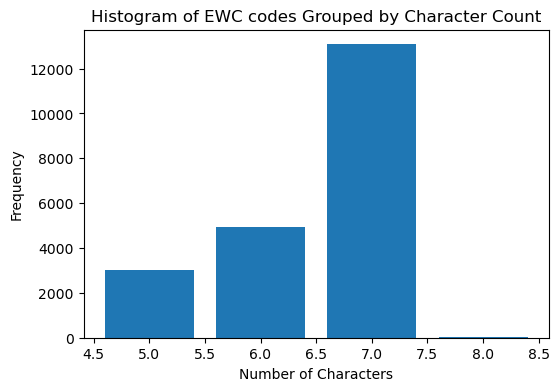

In [18]:
# A function to aid visualisation
def group_by_character_count(column):
    grouped_items = {}
    for item in column:
        char_count = len(item)
        if char_count not in grouped_items:
            grouped_items[char_count] = []
        grouped_items[char_count].append(item)
    # Plotting the histogram
    plt.figure(figsize=(6, 4))
    plt.bar(grouped_items.keys(), [len(items) for items in grouped_items.values()])
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.title('Histogram of EWC codes Grouped by Character Count')
    plt.show()
    return grouped_items

print(f'Before cleaning there are {len(ct_trim.EWC.unique())} unique EWC codes in the collection')
# Group by number of characters
grouped_items = group_by_character_count(ct_trim.EWC.values.astype('str'))


Plotting the frequecy distribution of EWC code length we find that there are a number that have 5 or 8 characters as well as the expected 6 or 7. This is typically due to their origin in Excel where numbers with preceding zeros will be truncated, yet EWC codes beginning with zero are legal values. Similarly to force Excel to treat a number as text it is sometimes preceded with an apostrophe.

Tidying up steps will be:
- Remove any rows without EWC codes
- Reomve any apostrophes
- Remove any asterisks
- Remove whitespaces
- Add zeros to the front of codes with 5 characters.
   

In [19]:
# Redefine params
ewc_params = {
    'et__column_name': 'EWC',
    'et__isalpha': False,
    'et__vector_size': 6,
    'et__window': 10,
    'et__min_count': 1,
    'et__sg': 1
}

# Create a pipeline to build a model
ewc_pipe = Pipeline([
    ('et', TextTransformer())
    #('et', FeatureHashingTransformer())
])

ewc_pipe.set_params(**ewc_params)

# Re-run the pipeline with new estimators
ewc_trim = ewc_pipe.fit_transform(ct_trim)
ewc_trim.head(2)

TextTransformer Start: (21042, 7)


TextTransformer: Successfully completed: EWC
TextTransformer: Finished EWC Shape: (21042, 12)
-------------------------------------------------------------------------


,Description,Components and Concentrations,Hazard Codes,UN Number,Disposal,Physical State,EWC_0,EWC_1,EWC_2,EWC_3,EWC_4,EWC_5
0,EMPTY PLASTIC DRUMS (60L),NIL HAZARDOUS COMPONENTS,N/C,NCAD,PACKCARE,SOLID,0.105848,-0.056756,-0.015773,0.096143,-0.125361,-0.065602
1,EMPTY PLASTIC DRUMS (30L),Nil hazardous components,N/C,NCAD,PACKCARE,SOLID,0.105848,-0.056756,-0.015773,0.096143,-0.125361,-0.065602


## Physical Form

A text field with categorical single word terms, since they are free text entry we should take a closer look.

There are 7 different forms: ['SOLID' 'LIQUID' 'MIXED' 'SLUDGE' 'GAS' 'LIQUID ' 'POWDER']
SOLID      9238
MIXED      6544
LIQUID     3983
SLUDGE      951
GAS         265
POWDER       57
LIQUID        4
Name: Physical State, dtype: int64


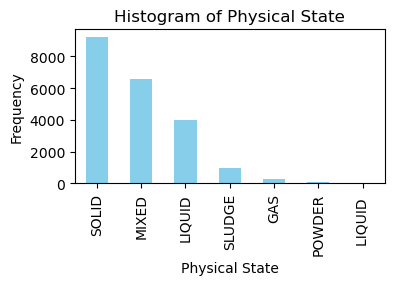

In [20]:
# Remove whitespaces
ewc_trim.Physical_State = ewc_trim['Physical State'].str.strip()

# Review a few properties
physical_state_unique = ewc_trim['Physical State'].unique()
print(f'There are {len(physical_state_unique)} different forms: {physical_state_unique}')
print(ewc_trim['Physical State'].value_counts())
create_histogram_from_column(ewc_trim, 'Physical State', 4, 2)

The physical state column appears to be clean data with low dimensionality therefore we can apply one hot encoding.

In [21]:
# Redefine params
ps_params = {
    'ps__column_name':'Physical State'
}

# Create a pipeline to build a model
ps_pipe = Pipeline([
    ('ps', OneHotTransformer())
])

ps_pipe.set_params(**ps_params)

# Re-run the pipeline with new estimators
ps_trim = ps_pipe.fit_transform(ewc_trim)

print(ps_trim.head(2))

OneHotTransformer Start: (21042, 12)
OneHotTransformer: Successfully completed: Physical State
OneHotTransformer: Finished Physical State Shape: (21042, 18)
-------------------------------------------------------------------------
                 Description Components and Concentrations Hazard Codes  \
0  EMPTY PLASTIC DRUMS (60L)      NIL HAZARDOUS COMPONENTS          N/C   
1  EMPTY PLASTIC DRUMS (30L)      Nil hazardous components          N/C   

  UN Number  Disposal     EWC_0     EWC_1     EWC_2     EWC_3     EWC_4  \
0      NCAD  PACKCARE  0.105848 -0.056756 -0.015773  0.096143 -0.125361   
1      NCAD  PACKCARE  0.105848 -0.056756 -0.015773  0.096143 -0.125361   

      EWC_5  Physical State_GAS  Physical State_LIQUID  \
0 -0.065602                   0                      0   
1 -0.065602                   0                      0   

   Physical State_LIQUID   Physical State_MIXED  Physical State_POWDER  \
0                       0                     0                     

## Disposal

The Disposal column contains the names of disposal outlets, in text, for simplicity these are converted into integer values that relate to their index position in an ordered list of unique values. This functionallity is provided by the IndexTransformer class.

In [22]:
# Redefine params
d_params = {
    'classifier__column_name':'Disposal'
}

# Create a pipeline to build a model
d_pipe = Pipeline([
    ('classifier', IndexTransformer())
])

d_pipe.set_params(**d_params)

# Re-run the pipeline with new estimators
d_trim = d_pipe.fit_transform(ps_trim)
print(d_trim.shape)

              Disposal  Disposal_Index
0             PACKCARE              25
1             PACKCARE              25
2             PACKCARE              25
3                  ERP              11
4  WASTECARE NORMANTON              42

IndexTransformer: Successfully completed: Disposal
IndexTransformer: Finished Disposal Shape: (21042, 19)
-------------------------------------------------------------------------
(21042, 19)


## Description

This is a short general description of the type of waste, typically less than ten words. This field and the Components field are filled with text, so we need to provide an estimator that can turn text into vectors.

In [23]:
# Redefine params
des_params = {
    'tt__column_name': 'Description',
    'tt__isalpha': True,
    'tt__vector_size': 100,
    'tt__window': 10,
    'tt__min_count': 1,
    'tt__sg': 0
}

# Create a pipeline to build a model
des_pipe = Pipeline([
    ('tt', TextTransformer())
])

des_pipe.set_params(**des_params)

# Re-run the pipeline with new estimators
des_trim = des_pipe.fit_transform(d_trim)
print(des_trim.head(2))
print(des_trim.shape)

TextTransformer Start: (21042, 19)


TextTransformer: Successfully completed: Description
TextTransformer: Finished Description Shape: (21042, 118)
-------------------------------------------------------------------------
  Components and Concentrations Hazard Codes UN Number  Disposal     EWC_0  \
0      NIL HAZARDOUS COMPONENTS          N/C      NCAD  PACKCARE  0.105848   
1      Nil hazardous components          N/C      NCAD  PACKCARE  0.105848   

      EWC_1     EWC_2     EWC_3     EWC_4     EWC_5  ...  Description_90  \
0 -0.056756 -0.015773  0.096143 -0.125361 -0.065602  ...        0.194338   
1 -0.056756 -0.015773  0.096143 -0.125361 -0.065602  ...        0.194338   

   Description_91  Description_92  Description_93  Description_94  \
0        0.267751       -0.260221        0.359845        0.456144   
1        0.267751       -0.260221        0.359845        0.456144   

   Description_95  Description_96  Description_97  Description_98  \
0         0.03282        0.462464       -0.585005       -0.608936   
1    

## UN Number

Legal values are NCAD for non hazardous material, or a four digit number that represents a particular category, i.e. non scalar values.

There are 184 unique UN Number values out of 21042 rows


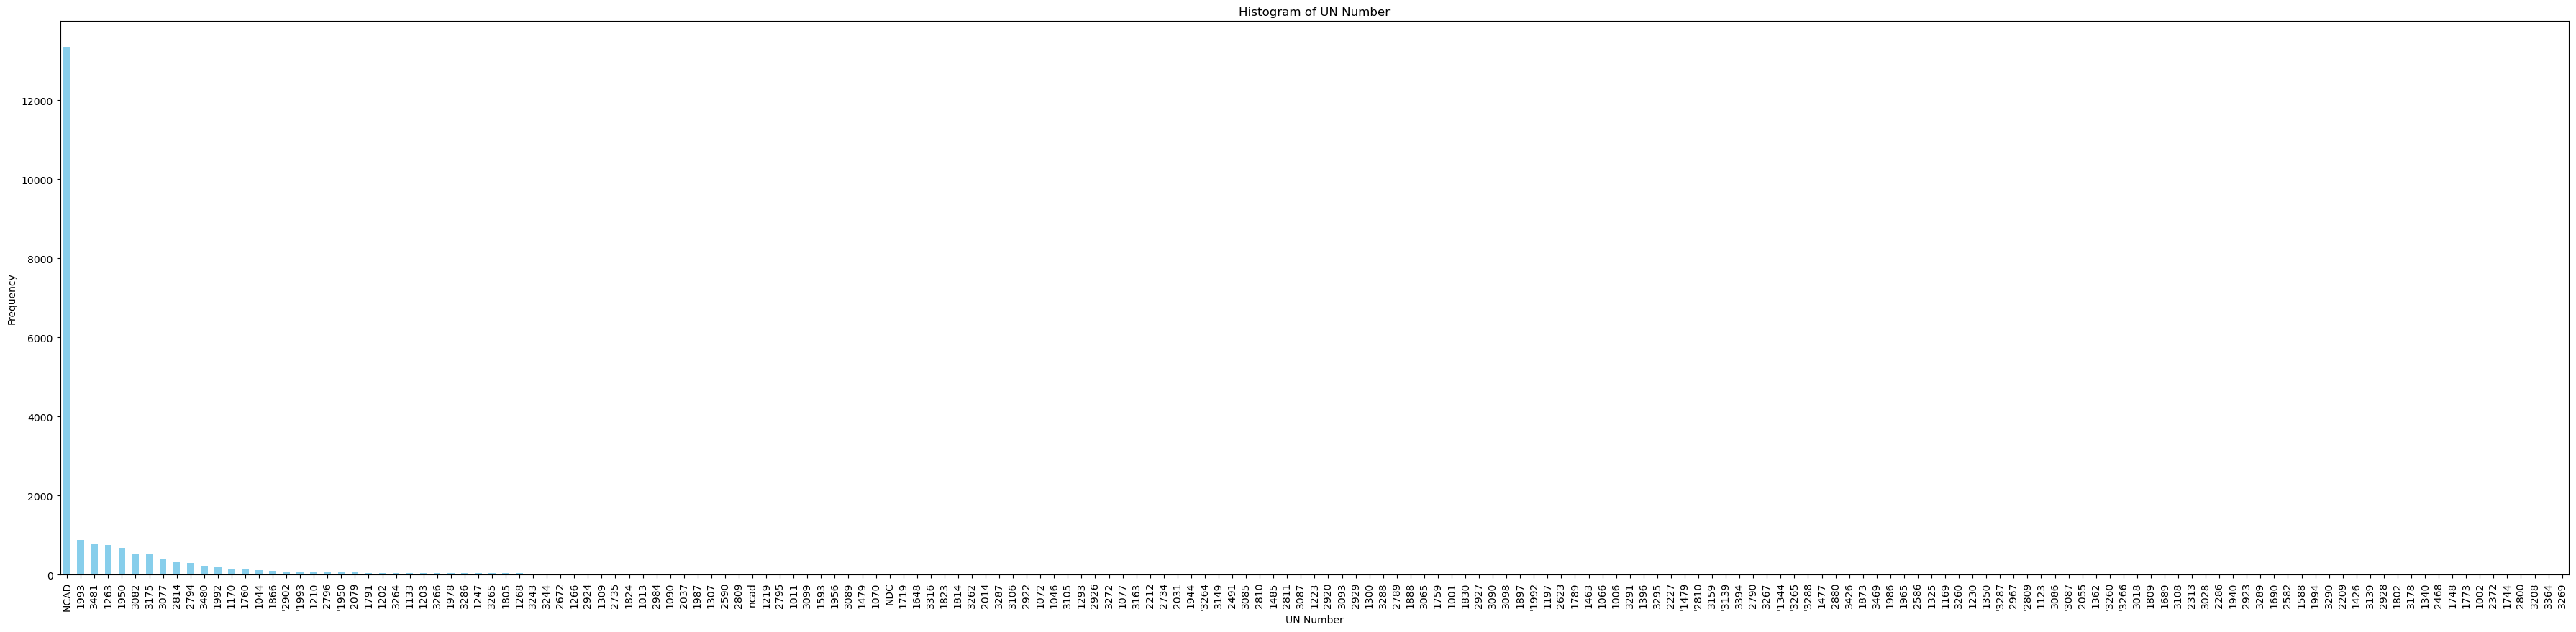

In [24]:
# Find unique values
un_numbers_unique = des_trim['UN Number'].unique()

# View results
print(f'There are {len(un_numbers_unique)} unique UN Number values out of { len(des_trim)} rows' )
create_histogram_from_column(des_trim, 'UN Number', 45, 10)

Similar to EWC codes, UN Numbers are categorical terms with a high number of possibilities, so feature hashing can be employed to reduce the number of dimensions.

In [25]:
# Redefine params
un_params = {
    'un__column_name': 'UN Number',
    'un__num_vec': 4
}

# Create a pipeline to build a model
un_pipe = Pipeline([
    ('un', FeatureHashingTransformer())
])

un_pipe.set_params(**un_params)

# Re-run the pipeline with new estimators
un_trim = un_pipe.fit_transform(des_trim)
print(un_trim.head(2))
print(un_trim.shape)

FeatureHashingTransformer Start: (21042, 118)
FeatureHashingTransformer: Successfully completed: UN Number
FeatureHashingTransformer: Finished UN Number Shape: (21042, 121)
-------------------------------------------------------------------------
  Components and Concentrations Hazard Codes  Disposal     EWC_0     EWC_1  \
0      NIL HAZARDOUS COMPONENTS          N/C  PACKCARE  0.105848 -0.056756   
1      Nil hazardous components          N/C  PACKCARE  0.105848 -0.056756   

      EWC_2     EWC_3     EWC_4     EWC_5  Physical State_GAS  ...  \
0 -0.015773  0.096143 -0.125361 -0.065602                   0  ...   
1 -0.015773  0.096143 -0.125361 -0.065602                   0  ...   

   Description_94  Description_95  Description_96  Description_97  \
0        0.456144         0.03282        0.462464       -0.585005   
1        0.456144         0.03282        0.462464       -0.585005   

   Description_98  Description_99  UN Number_0  UN Number_1  UN Number_2  \
0       -0.608936      

## Components and Concentrations

A list of component / concentration pairs, or if this is too complex "As list", or if non hazardous "Nil Hazardous Components".

This field has chemical names and concentrations which to a human reader with some knowledge of chemistry are easy to comprehend, to capture the same level of understanding at machine learning level though will be difficult. Not withstanding the additional complication of free text entry and typographical errors, there are several naming conventions for chemical names, new/old and very old, european, american... and so on. We also find "as list" and "nil hazardous components" in this field which are legitimate terms within the boundaries of waste description, but their level of abstractness circumnavigates any methodology relating to the recognition of chemical entities. Instead we shall consider a broader scope, that more closely matching the capture of meaning or semantics.

This field is rich in chemical nomenclature that form common word fragments. For example chemicals that contain one of the halogen elements, all have four character fragments such as fluo, chlo, brom, Iodo. Alkyl alcohols all contain a common term for the length of the carbon chain and end with 'anol', e.g. eth-anol, meth-anol, prop-anol. etc. Perhaps there is scope to consider fragmenting the words in this column and hoping that the most common chemical fragments will float to the top in a frequency distribution, but this asks the question of how to fragment and how many features would this create, for now we will consider only whole words, misspellings and all.

The simplest approach is the adoption of a 'bag of words', without necessarily concerning ourselves with word order or relationships between them. If we treat all words in the column as being the corpus, or bag, then we can assign a position or vector for each word, then averaging these provides us with a vector for the entire sentence. The learning aspect then involves estabilishing the proximity of similar vectors and associating these with a label.


In [26]:
# Redefine params
cc_params = {
    'cc__column_name': 'Components and Concentrations',
    'cc__isalpha': True,
    'cc__vector_size': 500,
    'cc__window': 10,
    'cc__min_count': 1,
    'cc__sg': 0
}

# Create a pipeline to build a model
cc_pipe = Pipeline([
    ('cc', TextTransformer())
])

cc_pipe.set_params(**cc_params)

# Re-run the pipeline with new estimators
cc_trim = cc_pipe.fit_transform(un_trim)
print(cc_trim.head(2))
print(cc_trim.shape)

TextTransformer Start: (21042, 121)


TextTransformer: Successfully completed: Components and Concentrations
TextTransformer: Finished Components and Concentrations Shape: (21042, 620)
-------------------------------------------------------------------------
  Hazard Codes  Disposal     EWC_0     EWC_1     EWC_2     EWC_3     EWC_4  \
0          N/C  PACKCARE  0.105848 -0.056756 -0.015773  0.096143 -0.125361   
1          N/C  PACKCARE  0.105848 -0.056756 -0.015773  0.096143 -0.125361   

      EWC_5  Physical State_GAS  Physical State_LIQUID  ...  \
0 -0.065602                   0                      0  ...   
1 -0.065602                   0                      0  ...   

   Components_and_Concentrations_490  Components_and_Concentrations_491  \
0                          -0.035684                          -0.016296   
1                          -0.035684                          -0.016296   

   Components_and_Concentrations_492  Components_and_Concentrations_493  \
0                           0.002196                 

## Hazard Codes

A list of codes relating to hazardous properties, from HP1 to HP15.

Each HP code can appear once in the list, furthermore these are categorical terms so we can adopt one hot encoding.

In [27]:
# A list of all legitimate values in the Hazard Codes column
hp_codes = ['HP1','HP2','HP3','HP4','HP5','HP6','HP7','HP8','HP9','HP10','HP11','HP12','HP13','HP14','HP15', 'NC','POP']
# Redefine params
hp_params = {
    'hp__column_name': 'Hazard Codes',
    'hp__tokens': hp_codes
}

# Create a pipeline to build a model
hp_pipe = Pipeline([
    ('hp', OneHotTokenTransformer())
])

hp_pipe.set_params(**hp_params)

# Re-run the pipeline with new estimators
hp_trim = hp_pipe.fit_transform(cc_trim)
print(hp_trim.head(2))
print(hp_trim.shape)

OneHotTokenTransformer Start: (21042, 620)
OneHotTokenTransformer: Successfully completed: Hazard Codes
OneHotTokenTransformer: Finished Hazard Codes Shape: (21042, 636)
-------------------------------------------------------------------------
   Disposal     EWC_0     EWC_1     EWC_2     EWC_3     EWC_4     EWC_5  \
0  PACKCARE  0.105848 -0.056756 -0.015773  0.096143 -0.125361 -0.065602   
1  PACKCARE  0.105848 -0.056756 -0.015773  0.096143 -0.125361 -0.065602   

   Physical State_GAS  Physical State_LIQUID  Physical State_LIQUID   ...  \
0                   0                      0                       0  ...   
1                   0                      0                       0  ...   

   HP8  HP9  HP10  HP11  HP12  HP13  HP14  HP15  NC  POP  
0    0    0     0     0     0     0     0     0   0    0  
1    0    0     0     0     0     0     0     0   0    0  

[2 rows x 636 columns]
(21042, 636)


## Combining Everything

Having looked at all feature columns and tested them as individual segments, we can now combine them all into one pipeline.

In [28]:
combined_params = {
    'rt__min_count': 5,
    'ct__filename': 'data/labels.xlsx',
    'et__column_name': 'EWC',
    'et__isalpha': False,
    'et__vector_size': 1,
    'et__window': 10,
    'et__min_count': 1,
    'et__sg': 1,
    'ps__column_name':'Physical_State',
    'cl__column_name':'Disposal',
    'tt__column_name': 'Description',
    'tt__isalpha': True,
    'tt__vector_size': 100,
    'tt__window': 10,
    'tt__min_count': 1,
    'tt__sg': 1,
    'un__column_name': 'UN_Number',
    'un__num_vec': 4,
    'cc__column_name': 'Components_and_Concentrations',
    'cc__isalpha': True,
    'cc__vector_size': 500,
    'cc__window': 10,
    'cc__min_count': 1,
    'cc__sg': 1,
    'hp__column_name': 'Hazard_Codes',
    'hp__classes': hp_codes
}

combined_params = {
    'rt__min_count': 5,
    'ct__filename': 'data/labels.xlsx',
    'et__column_name': 'EWC',
    'et__isalpha': False,
    'et__vector_size': [1,6],
    'et__window': 10,
    'et__min_count': 1,
    'et__sg': [0, 1],
    'ps__column_name':'Physical_State',
    'ps__isalpha': True,
    'ps__vector_size': [1,6],
    'ps__window': 10,
    'ps__min_count': 1,
    'ps__sg': [0, 1],
    'cl__column_name':'Disposal',
    'tt__column_name': 'Description',
    'tt__isalpha': True,
    'tt__vector_size': [100, 200],
    'tt__window': 10,
    'tt__min_count': 1,
    'tt__sg': [0, 1],
    'un__column_name': 'UN_Number',
    'un__isalpha': False,
    'un__vector_size': 1,
    'un__window': 10,
    'un__min_count': 1,
    'un__sg': [0, 1],
    'cc__column_name': 'Components_and_Concentrations',
    'cc__isalpha': True,
    'cc__vector_size': [500, 800],
    'cc__window': 10,
    'cc__min_count': 1,
    'cc__sg': [0, 1],
    'hp__column_name': 'Hazard_Codes',
    'hp__classes': hp_codes,
    'rf__n_estimators': [100, 200, 600],
    'rf__max_depth': [None, 1, 10],
    'rf__min_samples_split': [2, 10],
    'rf__min_samples_leaf': [2, 10],
    'rf__random_state': [2, 42]
}


# Create a pipeline to build a model 
pipeline = Pipeline([
    ('rt', RowTrimmer()),
    ('cn', CleanColumnNamesTransformer()),
    ('ct', ColumnTrimmer()),
    ('et', TextTransformer()),
    ('ps', OneHotTransformer()),
    ('cl', IndexTransformer()),
    ('tt', TextTransformer()),
    ('un', FeatureHashingTransformer()),
    ('cc', TextTransformer()),
    ('hp', OneHotTokenTransformer())
])


## Cross Validation

In [29]:
df_raw = pd.read_csv("data/raw3.csv")


In [30]:
# A list of all legitimate values in the Hazard Codes column
hp_codes = ['HP1','HP2','HP3','HP4','HP5','HP6','HP7','HP8','HP9','HP10','HP11','HP12','HP13','HP14','HP15', 'NC','POP']
physical_states = ['SOLID','SLUDGE','LIQUID','GAS','MIXED','POWDER']

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# Define the training set, typically called X
X = df_raw.drop('Disposal', axis=1)
print(X.shape)

# Define a column of labels
y = df_raw['Disposal']
print(y.shape)

(21045, 41)
(21045,)


In [31]:

#cross_val_score(pipeline2,X,y,cv=5,scoring='accuracy', error_score="raise")
# Re-run the pipeline with new estimators
#df_with_vectors = pipeline.fit_transform(df_raw)
#print(df_with_vectors.shape)

In [32]:
cv_params = {
    #'preprocessor__ewc__column_name': 'EWC',
    #'preprocessor__ewc__isalpha': False,
    #'preprocessor__ewc__vector_size': [6],
    #'preprocessor__ewc__window': 10,
    #'preprocessor__ewc__min_count': 1,
    'preprocessor__ewc__sg': [0, 1],
    #'preprocessor__phy__column_name':'Physical State',
    #'preprocessor__phy__tokens': physical_states,
    #'preprocessor__des__column_name': 'Description',
    #'preprocessor__des__isalpha': True,
    'preprocessor__des__vector_size': [100, 200],
    #'preprocessor__des__window': 10,
    #'preprocessor__des__min_count': 1,
    'preprocessor__des__sg': [0, 1],
    #'preprocessor__unn__column_name': 'UN Number',
    #'preprocessor__cnc__column_name': 'Components and Concentrations',
    #'preprocessor__cnc__isalpha': True,
    'preprocessor__cnc__vector_size': [500, 700],
    #'preprocessor__cnc__window': 10,
    #'preprocessor__cnc__min_count': 1,
    'preprocessor__cnc__sg': [0, 1],
    #'preprocessor__haz__column_name': 'Hazard Codes',
    #'preprocessor__haz__tokens': hp_codes,
    'classifier__n_estimators': [600, 700]
    #'classifier__max_depth': [None, 1, 10],
    #'classifier__min_samples_split': [2, 10],
    #'classifier__min_samples_leaf': [2, 10],
    #'classifier__random_state': [2, 42]
}

In [46]:
# Define the columns to remove numbers from
text_features = ['Description', 'Components and Concentrations', 'Physical State']
remove_numbers = ['Description', 'Components and Concentrations']
# Specify the maximum number of features for each column
max_features_per_column = {'Description': 200, 'Components and Concentrations': 500}

preprocessor = ColumnTransformer([
    ('txt', TextCleaner(remove_number_cols=remove_numbers), text_features)
    #('ewc', FeatureHashingTransformer(column_name='EWC', num_vec=6),['EWC']),
    #('des', TextTransformer(column_name='Description', isalpha=True, vector_size=200),['Description']),
    #('vec', ColumnVectorizer(preprocess_text=True,  
    #                         max_features_per_column=max_features_per_column),
    #                         ['Description', 'Components and Concentrations']),
    ##('cnc', TextTransformer(column_name='Components and Concentrations', isalpha=True, vector_size=500, sg=0),['Components and Concentrations']),
    #('phy', OneHotTokenTransformer(column_name='Physical State', tokens=physical_states),['Physical State']),    
    #('unn', FeatureHashingTransformer(column_name='UN Number'),['UN Number']),
    #('haz', OneHotTokenTransformer(column_name='Hazard Codes', tokens=hp_codes),['Hazard Codes'])
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=9, min_samples_split=2, min_samples_leaf=2, criterion='gini', verbose=True, n_jobs=-1))
])

from sklearn.model_selection import StratifiedKFold

# Create randomised folds that preserve the distribution of classes in each fold.
skf = StratifiedKFold(5, shuffle=True, random_state=1)

cross_val_score(pipe, X, y, cv=skf, scoring='roc_auc_ovr', error_score="raise")


ValueError: could not convert string to float: ''

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rand = RandomizedSearchCV(pipe, cv_params, cv=5, scoring='accuracy', random_state=1, n_iter=10, n_jobs=-1)
rand.fit(X,y)
rand.best_score_
rand.best_params_

In [ ]:
rand.best_score_
results = pd.DataFrame(rand.cv_results_)[['params','mean_test_score','rank_test_score']]
results.sort_values('rank_test_score')

# Training and Test Data
Finally we can split the data into training and testing sets, it's also good practise at this point to randomise, or shuffle the data set to remove any unwanted trending or sequencing.

## Splitting the Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Preserve our original data
#df_test = copy.deepcopy(df_with_vectors)

# Define the training set, typically called X
#X = df_test.drop(['Disposal_Index'], axis=1)
#X.head()
#X.shape

# Define a column of labels
#y = df_test['Disposal_Index']
#y.head()



In [ ]:
from sklearn.model_selection import cross_val_score
#cross_val_score(pipeline2, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A quick sanity check that our values arn't going to cause any problems in the next step.

In [ ]:
def checkValues(name, values):
    # Check for NaN values
    nan_indices = np.argwhere(np.isnan(values))
    print(name + " Indices of NaN values:", len(nan_indices))

    # Check for infinite values
    inf_indices = np.argwhere(np.isinf(values))
    print(name + " Indices of infinite values:", inf_indices)

    # Check for numbers too large for float64
    large_indices = np.argwhere(np.abs(values) > np.finfo(np.float64).max)
    print(name + " Indices of numbers too large for float64:", large_indices)
    
# Check for NaN, infinite or illegal numbers
checkValues('X_train', X_train.values)
print('')
checkValues('y_train', y_train.values)

## Hyperparamter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline with Random Forest classifier
pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

# Define the hyperparameters grid to search
param_grid = {
    'rf__n_estimators': [100, 200, 600],
    'rf__max_depth': [None, 1, 10],
    'rf__min_samples_split': [2, 10],
    'rf__min_samples_leaf': [2, 10],
    'rf__random_state': [2, 42]
}

# Best params from previous gridsearch, saves running the search every time we want to restart.
best_grid = {
    'rf__n_estimators': [250],
    'rf__max_depth': [None],
    'rf__min_samples_split': [2],
    'rf__min_samples_leaf': [2],
    'rf__random_state': [42]
}

# Perform Grid Search Cross Validation, exchange best_grid and param_grid
grid_search = GridSearchCV(pipeline, best_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", test_accuracy)

In [ ]:
import joblib

# Uncomment to save the trained model to a file
#joblib.dump(rf_model, 'c:/users/user/desktop/models/randomforrest_trained_model.pkl')

best_model = RandomForestClassifier(n_estimators=250, max_depth=None, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=8)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# Results Analysis

In [ ]:
# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
r_pred = [outlets.loc[t, 'Disposal'] for t in y_pred]
labels = sorted(set(r_test))
print(len(y_test.unique()))

In [ ]:
cm = confusion_matrix(r_test, r_pred)
print(cm.shape) 

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="Dark2_r", cbar_kws={'label': 'Count'})  
plt.show()

In [ ]:
cr = classification_report(r_test, r_pred)    
print(cr)

# Classification with XGBoost

In [ ]:
from xgboost import XGBClassifier

# import XGBoost
import xgboost as xgb

# Using the same data source as previous, but this time adding stratify=y when splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Hyperparameter Tuning with Hyperopt

In [ ]:
# define a search space
from hyperopt import hp, fmin, tpe, Trials

# Define the search space
space = { 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),    
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# Define the objective function for XGBoost classifier
def objective(params):
    # Extract hyperparameters
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']
    max_depth = params['max_depth']
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']

    # Define XGBoost parameters
    xgb_params = {
        'objective': 'multi:softmax',#
        'num_class': 47,  # Number of classes
        'eval_metric': 'merror',
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'verbosity': 0,
        'random_state':42
    }
    
    # Create DMatrix for training and testing data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test) 

    eval_set = [(dtrain, 'train'),(dtest, 'eval')]  # Specify the validation dataset

    eval_results = {}
    model = xgb.train(xgb_params, dtrain, early_stopping_rounds=10, num_boost_round=1000, evals=eval_set, evals_result=eval_results)
    
    # Make predictions on the test set
    y_pred = model.predict(dtest)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('----------------------------------')
    print(f'loss: {-accuracy}')
    print(f'learning_rate:{learning_rate}')
    print(f'max_depth:{max_depth}')
    print(f'n_estimators:{n_estimators}')
    print(f'subsample:{subsample}')
    print(f'colsample_bytree:{colsample_bytree}')
    print('----------------------------------') 
    return {
        'loss': -accuracy,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'eval_results': eval_results,
        'status': 'ok'
    }  # Minimize negative accuracy

# Perform hyperparameter optimization
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best hyperparameters:", best_params)


## View Results of Tuning

In [ ]:
# Plot the loss values
plt.plot(trials.losses())
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('Hyperopt XGBoost Trials')
plt.show()

In [ ]:

df_results = pd.DataFrame(trials.results)

def ScatterPlot(x, y, title):
    plt.scatter(x,y,marker='o')
    plt.xlabel(title)
    plt.ylabel('Loss')
    plt.title('Hyperopt XGBoost Trials - ' + title)
    plt.show()

In [ ]:
y = df_results['loss'].values
ScatterPlot(df_results['learning_rate'].values, y, 'Learning Rate')
ScatterPlot(df_results['n_estimators'].values, y, 'Num Estimators')
ScatterPlot(df_results['max_depth'].values, y, 'Max Depth')
ScatterPlot(df_results['subsample'].values, y, 'Subsample')
ScatterPlot(df_results['colsample_bytree'].values, y, 'colsample_bytree')

## Training a Model with Tuned Parameters

In [ ]:
best = {
    'learning_rate': 0.1624673203663925,
    'max_depth': int(10),
    'n_estimators': int(488),
    'subsample': 0.9513666706021229,
    'colsample_bytree': 0.6887720706933753
}

best = trials.best_trial['result']

In [ ]:

# Define XGBoost parameters
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 47,  # Number of classes
    'eval_metric': 'merror',
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    #'verbosity': 0
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)  # Assuming y_test is available for evaluation

eval_set = [(dtrain, 'train'),(dtest, 'eval')]  # Specify the validation dataset

eval_results = {}
xgb_model = xgb.train(xgb_params, dtrain, early_stopping_rounds=10, num_boost_round=1000, evals=eval_set, evals_result=eval_results)


In [ ]:
train_error = eval_results['train']['merror']
val_error = eval_results['eval']['merror']

plt.plot(train_error, label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('Boosting Round')
plt.ylabel('Multiclass Error')
plt.legend()
plt.show()

In [ ]:
import joblib
# Save the trained model to a file
#joblib.dump(xgb_model, 'c:/users/user/desktop/models/xgboost_trained_model.pkl')

## Predictions with XGBoost Model

In [ ]:
# make predictions on test data
y_pred = xgb_model.predict(dtest)
print(y_test.head())


In [ ]:
# Predict probabilities
print(xgb_model.best_ntree_limit)
print(xgb_model.best_iteration)
print(xgb_model.best_score)

## Results Analysis

### Accuracy

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

### Classification Report

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred))

### Feature Importance

In [ ]:
# Feature Importance
from xgboost import plot_importance

# Plot feature importance for the top 30 features
plot_importance(xgb_model, max_num_features=20)

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm.shape) 

# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
labels = sorted(set(r_test))

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set_theme(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="coolwarm", cbar_kws={'label': 'Count'})  
plt.show()